In [8]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import os
from tqdm.notebook import tqdm
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

sns.set_style("darkgrid")
pd.set_option('mode.chained_assignment',None)

In [9]:
train_file = os.getcwd() + '/playground-series-s3e14/train.csv'
test_file = os.getcwd() + '/playground-series-s3e14/test.csv'
original = os.getcwd() + '/playground-series-s3e14/WildBlueberryPollinationSimulationData.csv'

In [10]:
def get_datasets(filename):
    df = pd.read_csv(filename)
    return df

In [11]:
get_datasets(train_file).head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


In [12]:
get_datasets(test_file).head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,15289,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.399367,0.408088,31.394569
1,15290,12.5,0.25,0.25,0.75,0.63,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.488048,0.442866,36.846956
2,15291,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.583379,0.487057,40.037644
3,15292,25.0,0.50,0.38,0.38,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.433014,0.422847,33.116091
4,15293,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.360996,0.388860,29.558019


In [13]:
get_datasets(original).head()

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,1,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.444254,0.425458,33.449385,4947.605663
2,2,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.383787,0.399172,30.546306,3866.798965
3,3,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.407564,0.408789,31.562586,4303.943030
4,4,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.354413,0.382703,28.873714,3436.493543


In [14]:
def drop_columns(col_name,dataframe):
    dataframe.drop(col_name,axis=1,inplace=True)
    return dataframe

train = drop_columns('id',get_datasets(train_file))
original = drop_columns('Row#',get_datasets(original))

In [15]:
def concat_dataframe(df1,df2):
    return pd.concat([df1,df2])

df_full = concat_dataframe(train, original)

In [16]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    summ['inf'] = np.isinf(df).sum().sum()
    summ['duplicate'] = df.duplicated().sum()
    return summ

In [17]:
summary('full_dataset',df_full)

full_dataset shape: (16066, 17)


,dtypes,null,unique,min,median,max,mean,std,inf,duplicate
clonesize,float64,0,6,10.000000,25.000000,40.000000,19.659374,6.618134,0,7
honeybee,float64,0,7,0.000000,0.500000,18.430000,0.390660,0.413259,0,7
bumbles,float64,0,12,0.000000,0.250000,0.585000,0.286556,0.060249,0,7
andrena,float64,0,17,0.000000,0.500000,0.750000,0.491522,0.148849,0,7
osmia,float64,0,16,0.000000,0.630000,0.750000,0.590890,0.141209,0,7
MaxOfUpperTRange,float64,0,6,69.700000,86.000000,94.600000,82.175072,9.148725,0,7
MinOfUpperTRange,float64,0,5,39.000000,52.000000,57.200000,49.674599,5.548630,0,7
AverageOfUpperTRange,float64,0,5,58.200000,71.900000,79.000000,68.659486,7.643286,0,7
MaxOfLowerTRange,float64,0,6,50.200000,62.000000,68.200000,59.233400,6.612254,0,7
MinOfLowerTRange,float64,0,7,24.300000,30.000000,33.000000,28.661988,3.195960,0,7


In [18]:
def drop_dups(df):
    return df.drop_duplicates()
df_full = drop_dups(df_full)

In [19]:
def generate_features(df):
    df["fruit_seed"] = df["fruitset"] * df["seeds"]
    df['insects'] = df['honeybee'] + df['bumbles'] + df['andrena'] + df['osmia']
    df["AverageTRange"]=(df["AverageOfUpperTRange"]+df["AverageOfLowerTRange"])/2
    df["total_bees"] = df["honeybee"] + df["bumbles"] + df["andrena"] + df["osmia"]
    df["temperature_range"] = df["MaxOfUpperTRange"] - df["MinOfUpperTRange"] + df["MaxOfLowerTRange"] - df["MinOfLowerTRange"]
    df["rainfall_intensity"] = df["RainingDays"] * df["AverageRainingDays"]
    df["fruit_quality"] = df["fruitset"] * df["fruitmass"]
    df["seed_to_fruit_ratio"] = df["seeds"] / df["fruitmass"]
    
    temperature_ranges = ["MaxOfUpperTRange", "MinOfUpperTRange", "AverageOfUpperTRange","MaxOfLowerTRange", "MinOfLowerTRange", "AverageOfLowerTRange"]
    pca = PCA(n_components=1)
    df[["pca_temperature"]] = pca.fit_transform(df[temperature_ranges])
    df = df.drop(temperature_ranges, axis=1)
    return df



df_full=generate_features(df_full)
test = generate_features(get_datasets(test_file))

<Axes: xlabel='yield', ylabel='Density'>

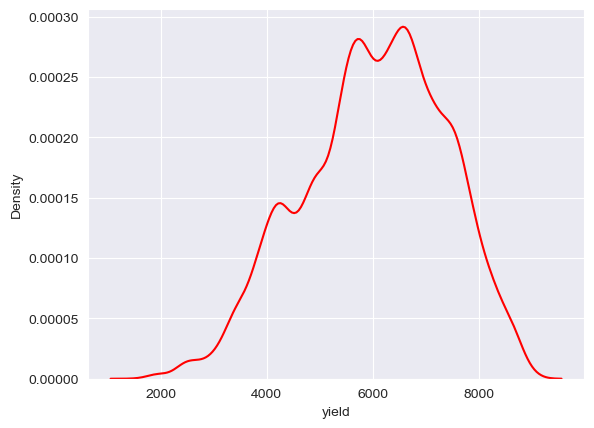

In [20]:
sns.kdeplot(df_full,x='yield',color='r')

In [21]:
def generate_features_labels(df,target_name):
    if target_name =='yield':
        label = df[target_name]
        features=drop_columns(target_name,df)
        return features,label
    elif target_name=='test':
        features=df.loc[:, df.columns != 'id']
        return features

X,y = generate_features_labels(df_full,'yield')

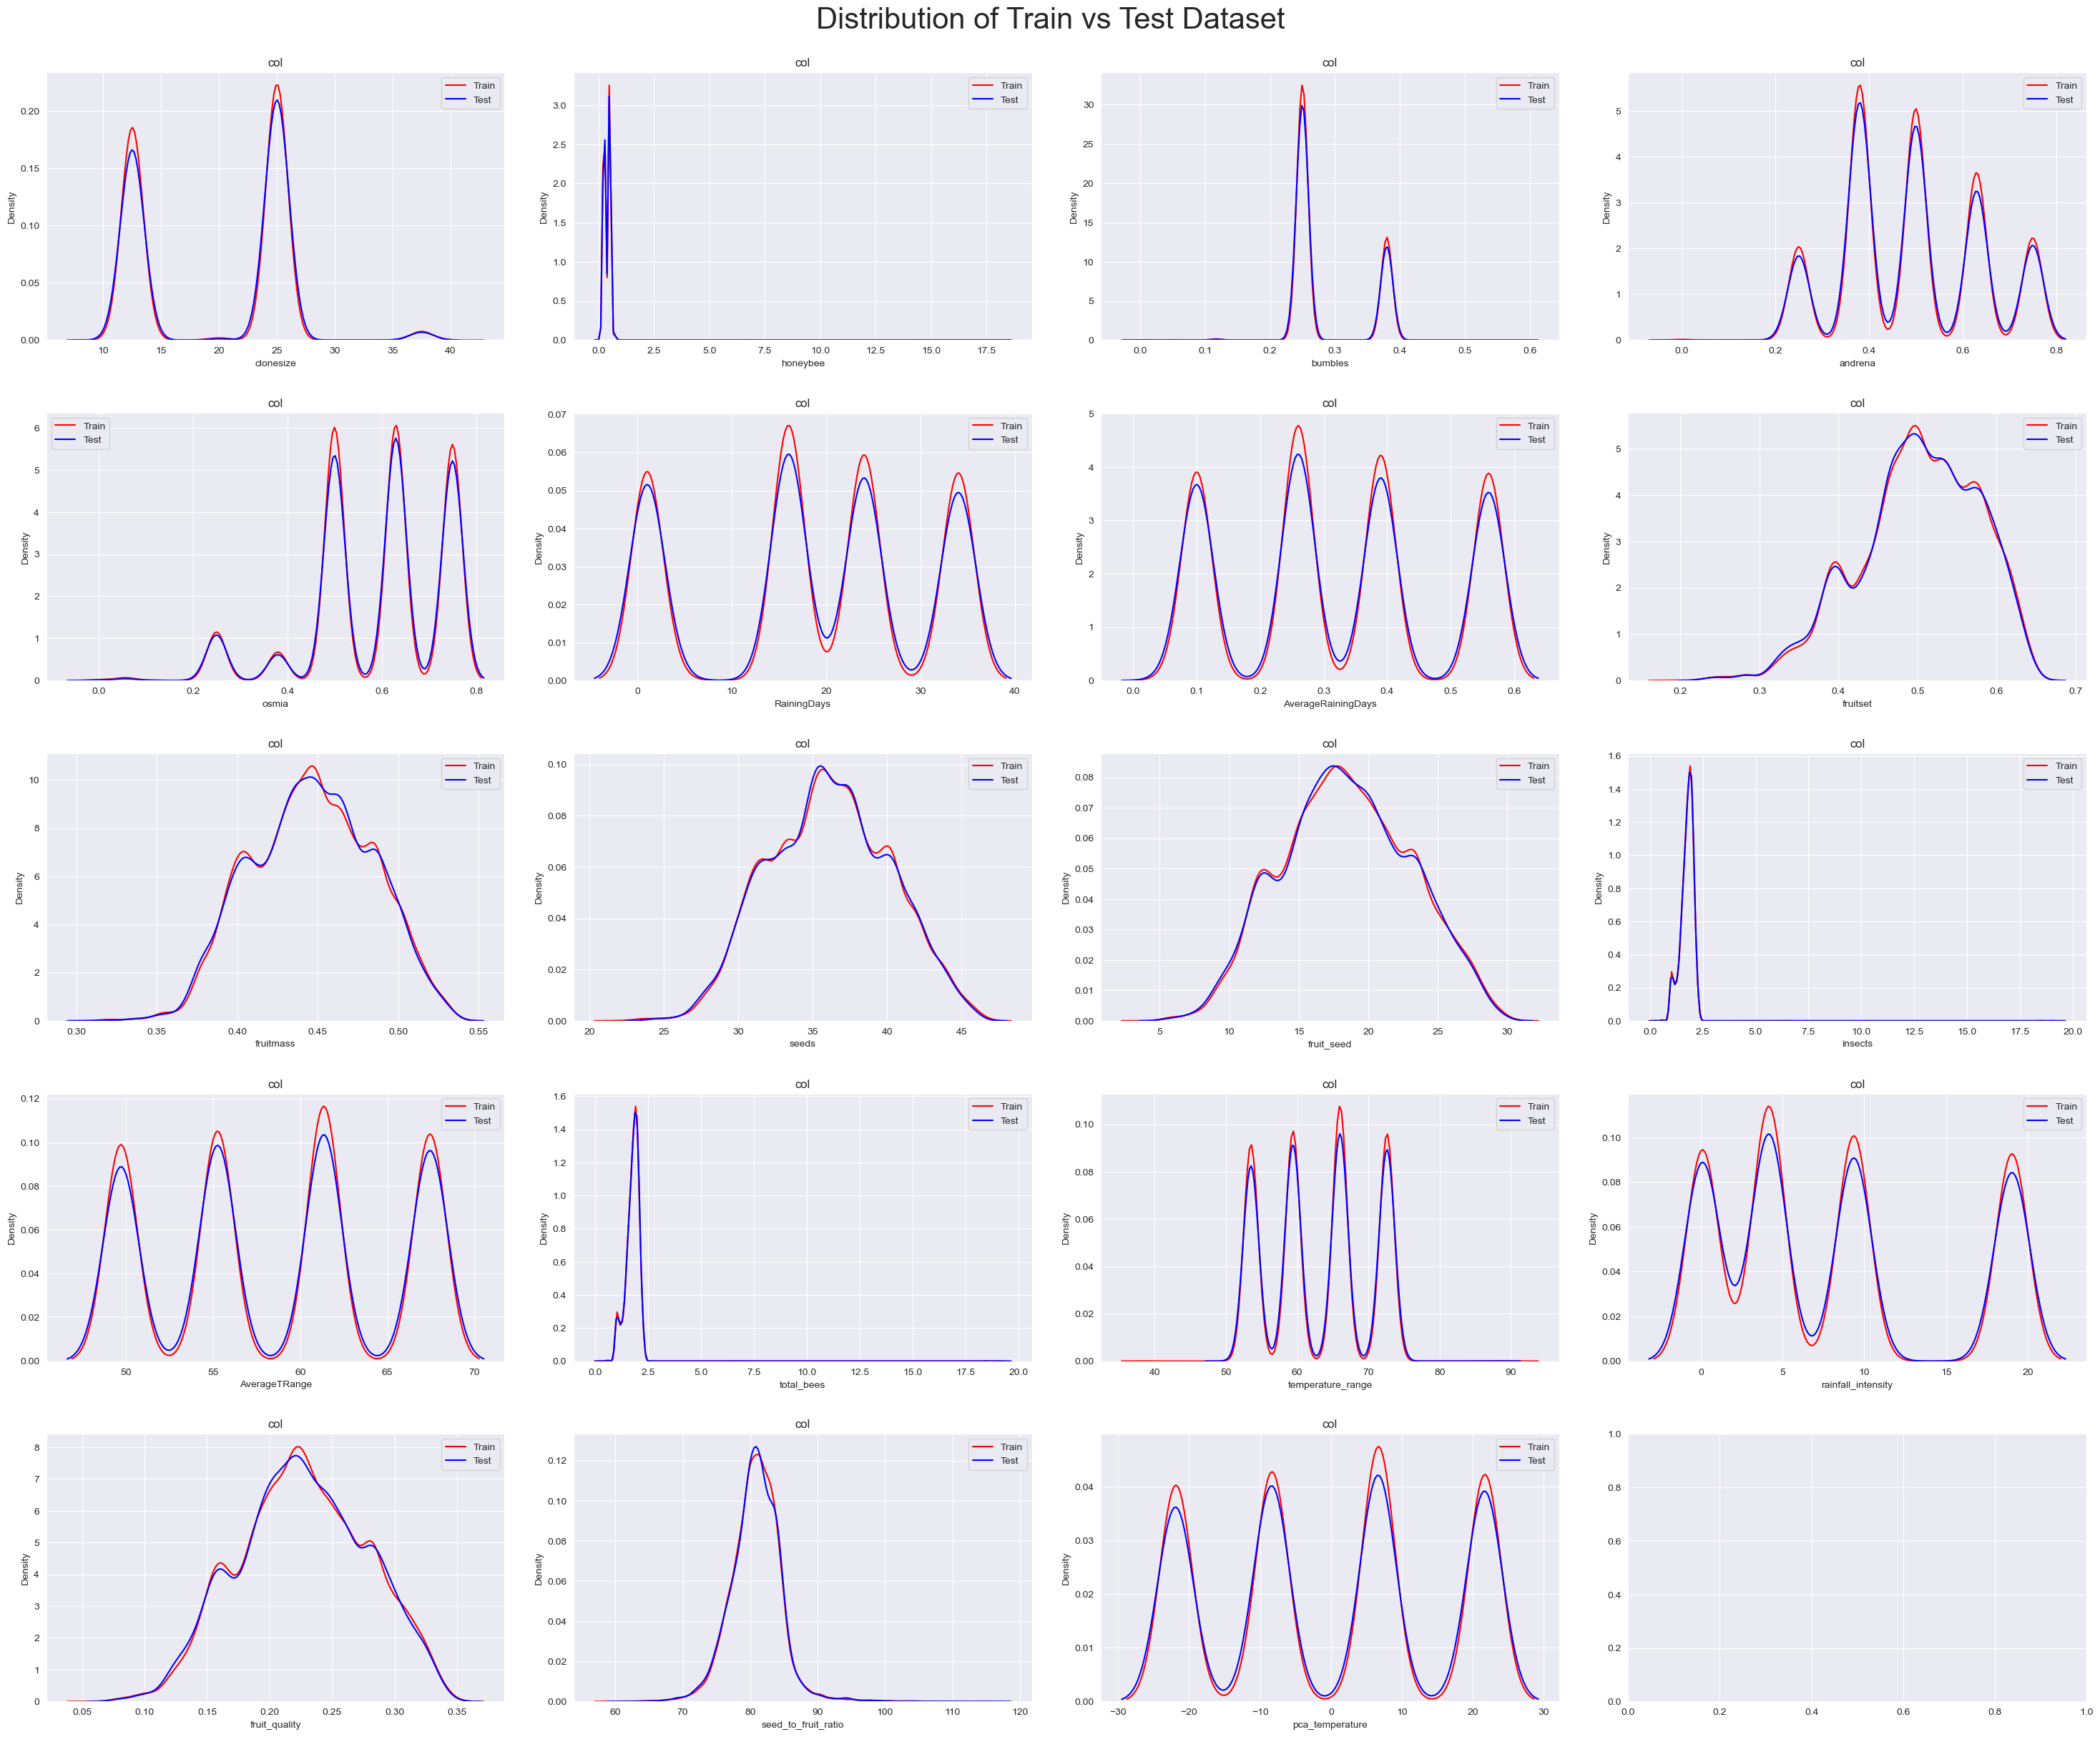

In [22]:
def plot_kde_train_test(features,test_df):
    fig,ax = plt.subplots(int(np.ceil(len(features.columns)/4)),4, figsize = (30,25))
    for i,col in enumerate(features.columns):
        ax = np.ravel(ax)
        sns.kdeplot(x= features[col] , label = 'Train', ax = ax[i],color='r')
        sns.kdeplot(x= test_df[col], label = 'Test', ax = ax[i] ,color='b')
        ax[i].legend()
        ax[i].set_title(f"col")

    plt.suptitle("Distribution of Train vs Test Dataset",fontsize = 30)
    plt.tight_layout(pad =3)
    plt.show()
    
plot_kde_train_test(X,test)

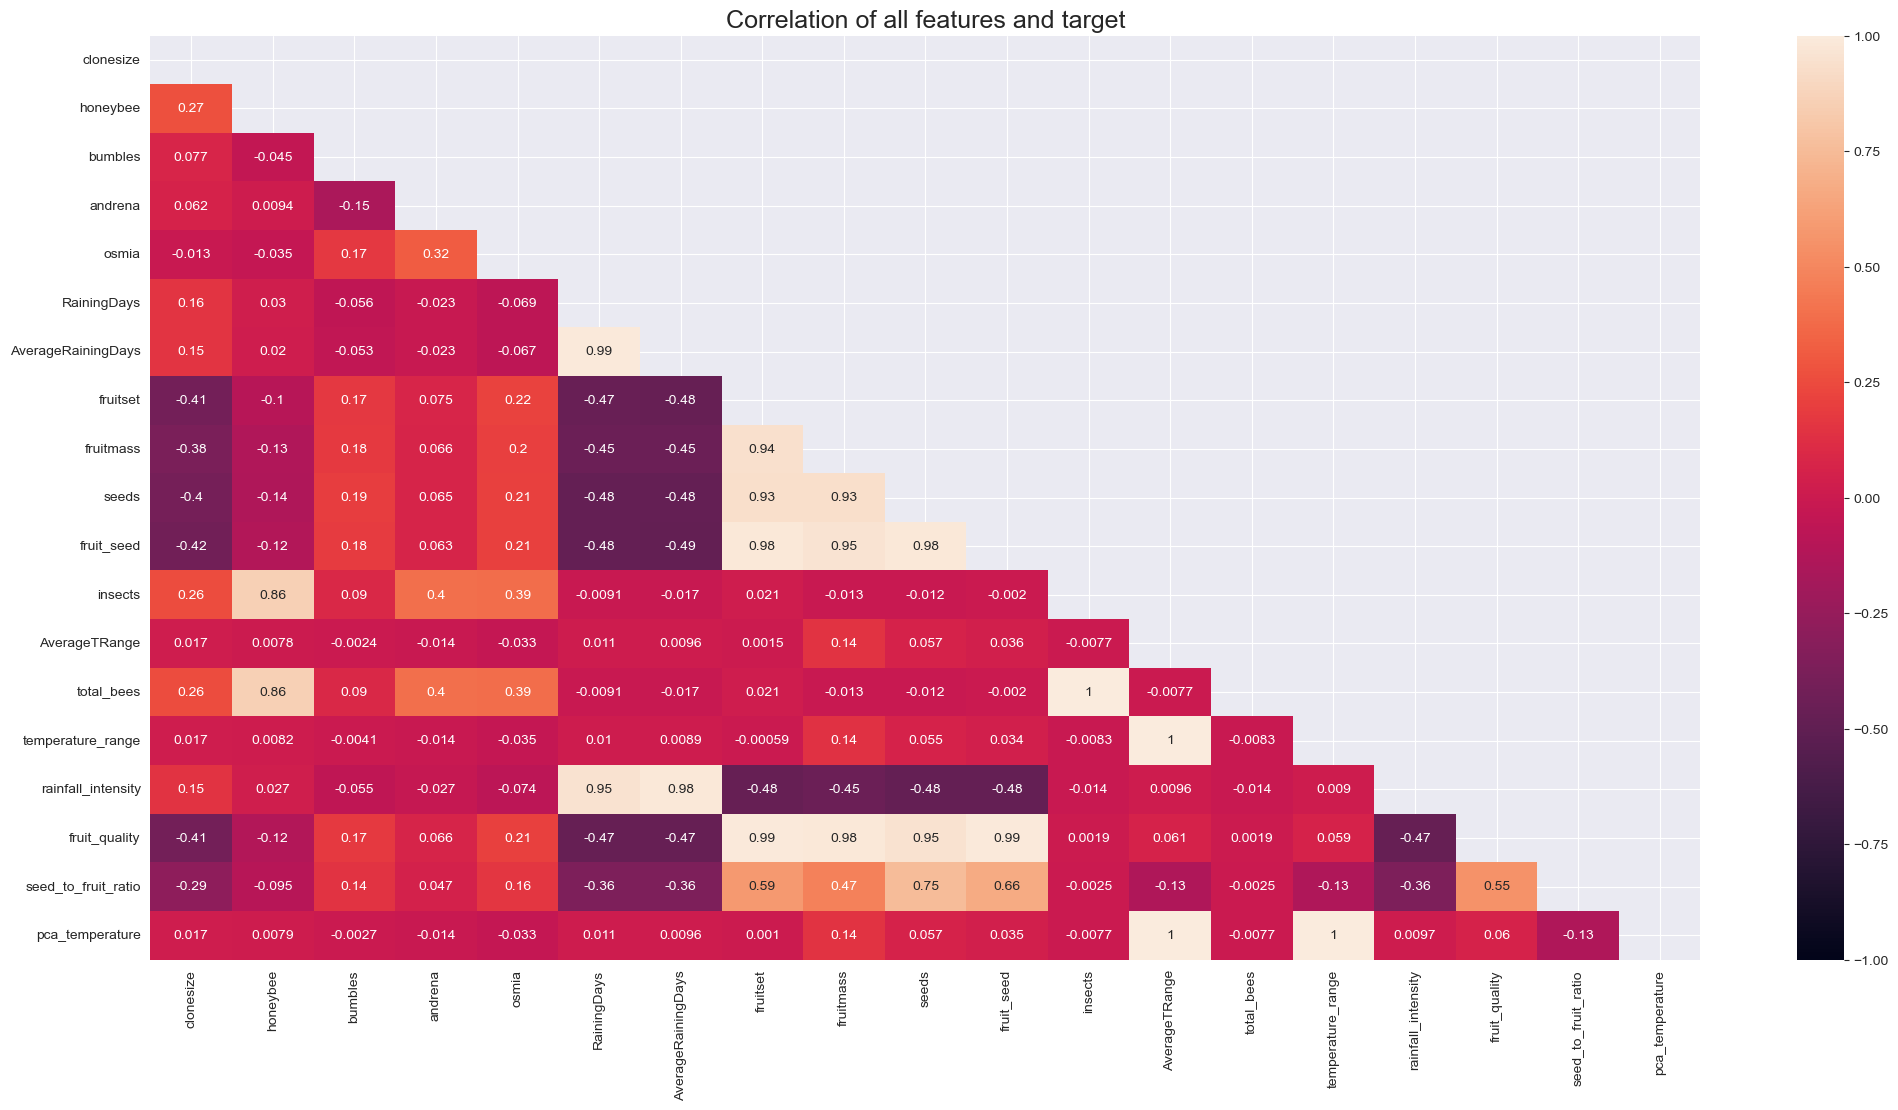

In [23]:
def  plot_correlation_dataset(df):
    plt.figure(figsize = (25,12))
    corr = df.corr()
    upper_triangle = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr,vmin = -1, vmax = 1, cmap = "rocket", annot = True, mask = upper_triangle)
    plt.title("Correlation of all features and target", fontsize= 18)
    plt.show()
    
plot_correlation_dataset(X)

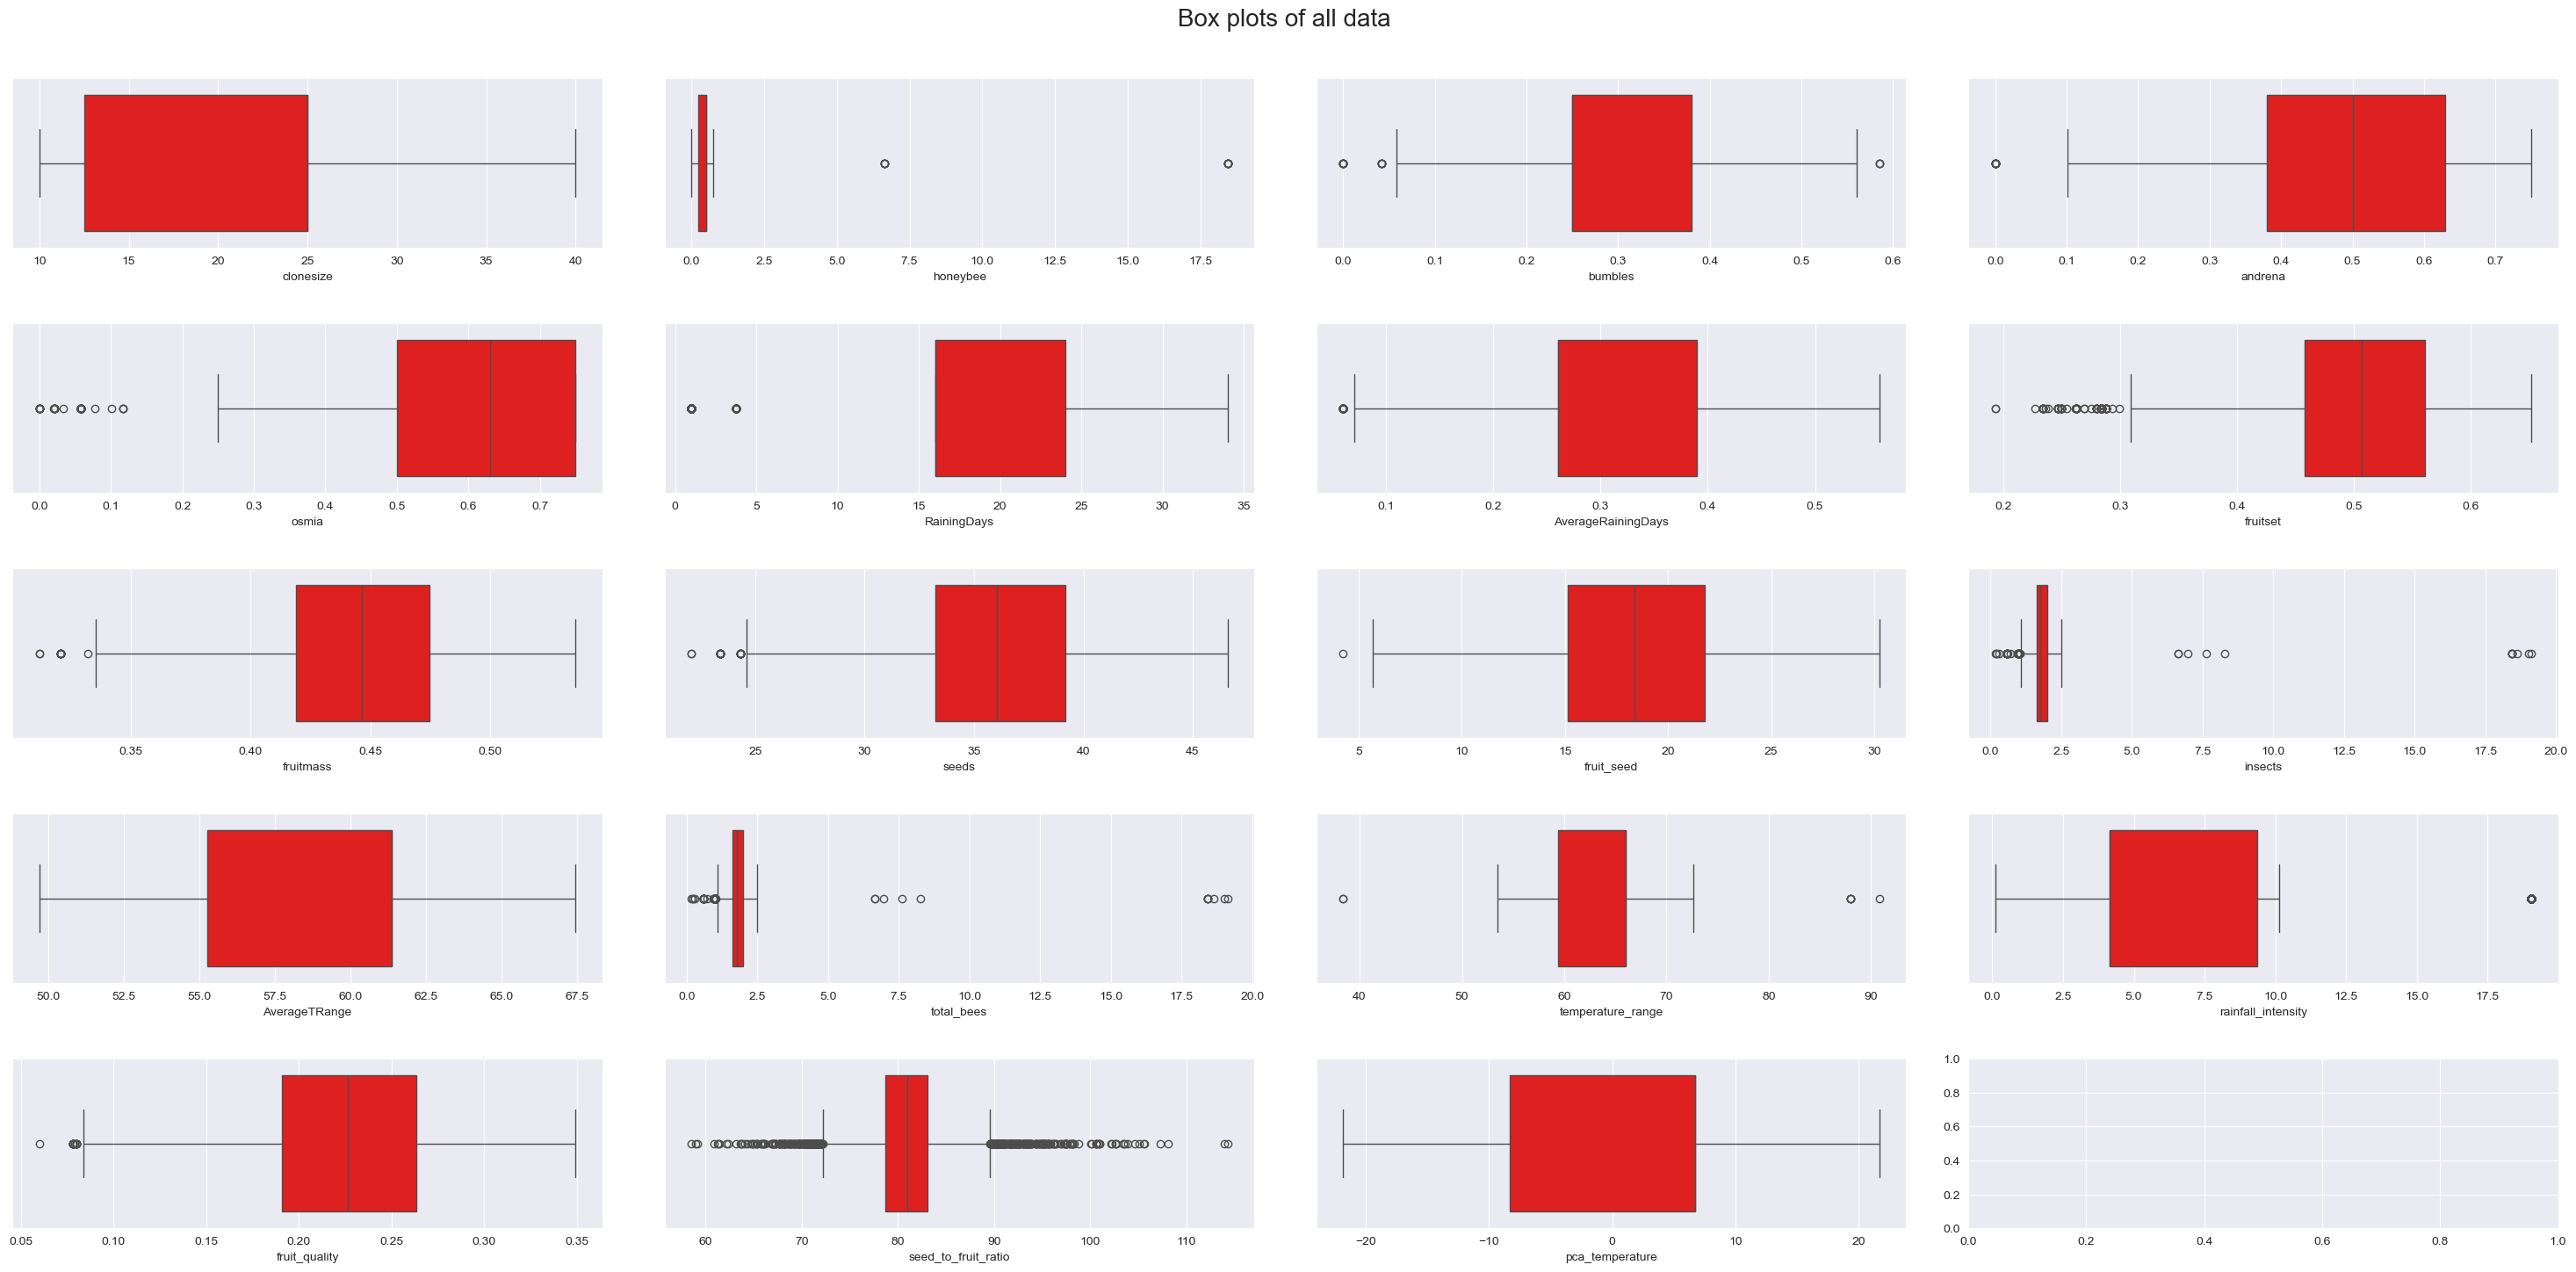

In [24]:
def show_outlier(features):
    fig,ax = plt.subplots(int(np.ceil(len(X.columns)/4)),4,figsize = (30,15))
    ax = np.ravel(ax)
    for i,col in enumerate(X.columns):
        sns.boxplot(ax = ax[i], x = X[col], color= "red")
    fig.suptitle("Box plots of all data ",fontsize = 20)
    plt.tight_layout(pad=3)
    plt.show()

show_outlier(X)

In [25]:
def preprocessing(features,label=None):
    scaler = StandardScaler()
    num_cols = list(features.select_dtypes(include=['int','float']))
    features = scaler.fit_transform(features[num_cols].values)
    if label is not None:
        return train_test_split(features,label.to_numpy(),test_size=0.2,random_state=42)
    elif label is None:
        return features

X_train,X_test,y_train,y_test = preprocessing(X,y)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(12847, 19) (3212, 19) (12847,) (3212,)


In [26]:
def convert_to_torch(value):
    return torch.tensor(data=value,dtype=torch.float32,requires_grad=True)

In [27]:
class Data(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

X_data = convert_to_torch(X_train)
y_data = convert_to_torch(y_train)
X_test = convert_to_torch(X_test)
y_test = convert_to_torch(y_test)
train_data = Data(X_data,y_data)
test_data = Data(X_test,y_test)

In [28]:
class RegressionBaseModel(torch.nn.Module):
    
    def training_step(self,batch):
        features,labels = batch
        out = self(features)
        loss = F.l1_loss(out,labels.unsqueeze(1))
        return loss
    
    def test_step(self, batch):
        features, labels = batch 
        out = self(features)                    
        loss = F.l1_loss(out, labels.unsqueeze(1))          
        return {'test_loss': loss.detach()}
        
    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        return {'test_loss': epoch_loss.item()}
    
    
    def epoch_end(self, epoch, result):
        if epoch %10 ==0:
            print("Epoch [{}], train_loss: {:.5f}, test_loss: {:.5f}".format(
                (epoch+10), result['train_loss'], result['test_loss']))

In [29]:
class RegressionBlueBerryNNet(RegressionBaseModel):
    def __init__(self,input_features):
        super().__init__()
        self.network = torch.nn.Sequential(
        torch.nn.Linear(input_features,1),
        torch.nn.LeakyReLU()
        )
    def forward(self,inputs):
        return self.network(inputs)

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [45]:
model = RegressionBlueBerryNNet(X_train.shape[1])
#model.to(device)

In [32]:
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.1
MOMENTUM = 0.9
OPT_FUNC= torch.optim.SGD

In [42]:
def get_dataloaders(dataset_type,batch,shuffle):
    if shuffle:
         return DataLoader(dataset=dataset_type, batch_size=batch, shuffle=True)
    else:
        return DataLoader(dataset=dataset_type, batch_size=batch,shuffle=False)

In [46]:
@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.test_step(batch) for batch in test_loader]
    return model.test_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, test_loader, opt_func):
    model.train()
    history = []
    optimizer = opt_func(model.parameters(),lr,MOMENTUM)
    for epoch in tqdm(range(epochs)): 
        train_losses = []
        for batch in train_loader:
            optimizer.zero_grad()
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss)
            
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    print('Training is completed!!')
    return history

In [47]:
train_dataloader = get_dataloaders(train_data,BATCH_SIZE,True)
test_dataloader = get_dataloaders(test_data,BATCH_SIZE,False)
history = fit(EPOCHS, LEARNING_RATE, model, train_dataloader, test_dataloader,OPT_FUNC)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10], train_loss: 5755.14746, test_loss: 5513.10156
Epoch [20], train_loss: 4163.21338, test_loss: 4108.16846
Epoch [30], train_loss: 707.23950, test_loss: 593.84100
Epoch [40], train_loss: 364.01031, test_loss: 370.13770
Epoch [50], train_loss: 359.00217, test_loss: 365.63889
Epoch [60], train_loss: 358.14188, test_loss: 365.05936
Epoch [70], train_loss: 357.34048, test_loss: 364.26144
Epoch [80], train_loss: 357.24829, test_loss: 364.26993
Epoch [90], train_loss: 356.93848, test_loss: 363.96219
Epoch [100], train_loss: 356.99719, test_loss: 363.98407
Training is completed!!


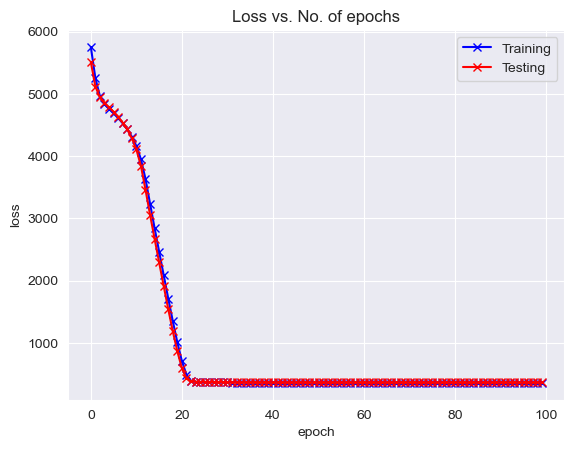

In [48]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    test_losses = [x['test_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(test_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Testing'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [49]:
torch.save(model,os.getcwd() + '/RegressionBB.pt')

In [50]:
summary('test',test)

test shape: (10194, 20)


,dtypes,null,unique,min,median,max,mean,std,inf,duplicate
id,int64,0,10194,15289.000000,20385.500000,25482.000000,2.038550e+04,2942.898656,0,0
clonesize,float64,0,5,10.000000,25.000000,37.500000,1.979596e+01,6.591864,0,0
honeybee,float64,0,7,0.000000,0.500000,18.430000,3.916056e-01,0.390022,0,0
bumbles,float64,0,8,0.000000,0.250000,0.585000,2.863074e-01,0.059867,0,0
andrena,float64,0,12,0.000000,0.500000,0.750000,4.913282e-01,0.148166,0,0
osmia,float64,0,14,0.000000,0.630000,0.750000,5.932218e-01,0.139897,0,0
RainingDays,float64,0,6,1.000000,16.000000,34.000000,1.850736e+01,11.780074,0,0
AverageRainingDays,float64,0,5,0.060000,0.260000,0.560000,3.225015e-01,0.165342,0,0
fruitset,float64,0,1209,0.233554,0.506346,0.652144,5.018087e-01,0.074707,0,0
fruitmass,float64,0,1299,0.311921,0.446570,0.535660,4.463447e-01,0.037054,0,0


In [51]:
X_val=generate_features_labels(test,'test')
X_num_test=preprocessing(X_val)

In [52]:
model_test = torch.load(os.getcwd() + '/RegressionBB.pt')
#model_test.to(device)

In [53]:
class Data_Test(Dataset):
    
    def __init__(self, X_test_data):
        self.X_test_data = X_test_data
        
    def __getitem__(self, index):
        return self.X_test_data[index]
        
    def __len__ (self):
        return len(self.X_test_data)

In [58]:
def eval_test_data(model,testing_data_dl):
    yield_target = []
    model.eval()
    with torch.no_grad():
        for X_batch_test in testing_data_dl:
            #X_batch_test = X_batch_test.to(device)
            y_test_pred = model(X_batch_test)
            y_pred_tag = torch.round(y_test_pred)
            yield_target.append(y_pred_tag.cpu().numpy())
    return [a.squeeze().tolist() for a in yield_target]

In [59]:
testing_data = Data_Test(convert_to_torch(X_num_test))
testing_data_loader = DataLoader(dataset=testing_data, batch_size=BATCH_SIZE)

In [60]:
def submit_test_data():
    yield_submission=[]
    for elements in  eval_test_data(model_test,testing_data_loader):
        for field in elements:
            yield_submission.append(field)    
    return yield_submission

In [64]:
yhat = submit_test_data()
df_submit = pd.DataFrame(data={'id': test['id'],'yield': yhat})
df_submit.head()
df_submit.to_csv("submission.csv", index=False)
print('Submission Completed!!')

Submission Completed!!
